https://institutefordiseasemodeling.github.io/Documentation/general/model-overview.html

Coursera: https://www.coursera.org/learn/epidemics

- $\beta =$ infectiousness of disease.

- $\gamma = 1/D$ where $D$ is the average duration of infection.


SI:
Once infected, stay infected forever. Infinite duration of infection, i.e. $\gamma = 0$, no healing. Like herpes.

SIS:
Once infected, can heal and become susceptible again. $\gamma > 0$. Like common cold.

SIR:
Immune after recovery, like chicken-pox.


- Time to kill: Death after certain time of fully having the disease, dict of runs with disease
- Susceptibility: Different susceptibility per person, dict susceptibility, affects rate beta

In [1]:
import networkx as nx
import numpy as np
from random import sample

import matplotlib.pyplot as plt
plt.set_cmap('Reds')
from matplotlib.colors import rgb2hex

### Random network generator

In [2]:
# The adjacency matrix (float full matrix)
def adj_mat(g):
    """Returns a dense adjacency matrix for a graph g"""
    return np.array(nx.adjacency_matrix(g).todense(), dtype=np.float64)

# randoms
from numpy.random import rand, choice

def random_adjmat(n, p=0.5):
    """Returns a graph where each edge appears with probability p"""
    X = rand(n, n)
    X[X < np.sqrt(1 - p)] = 0
    X[np.logical_or(X > 0, X.T > 0)] = 1
    np.fill_diagonal(X, 0)
    return X

def random_network(n, p=0.5):
    """Returns a networkx graph with n vertices where each edge 
    appears with probability p"""
    return nx.from_numpy_array(random_adjmat(n, p))

### Draw netwrok

In [3]:
def draw_network(g, pos=None, title=None):
    # create colourmap from the spins
    #cmap = [infection for node,infection in nx.get_node_attributes(g, 'infection').items()]
    
    n = len(g)
    colouring = []
    reds = plt.get_cmap('Reds')
    
    for i in range(n):
        
        node = g.nodes[i]
        
        if node['life_state'] == 0:
            colour = '#808080' #grey
        elif node['recovery_state'] == 1:
            colour = '#66CC00' #shrek green
        else:
            colour = rgb2hex(reds(node['infection']*0.99)[:3])
        
        colouring.append(colour)

    # creating positions for drawing
    if type(pos) == tuple:
        n,m = pos
        pos = {node: (node//n,node%n) for node in g.nodes}
    
    nx.draw_networkx_nodes(g,pos,node_color=colouring,vmin=0,vmax=1,node_size=75)
    edgelist = [edge for edge in g.edges]
    nx.draw_networkx_edges(g, pos, edgelist,width=0.5)

    # if a title is supplied, add it to the plot
    if title:
        plt.title(title)
        
    plt.axis('off')

### Modelling

In [4]:
def update_node(old_infection,m,beta,duration,sus):
    
    new_node_infection = old_infection + sus*beta*m - 1/duration
        
    if new_node_infection < 0:
        new_node_infection = 0
    elif new_node_infection > 1:
        new_node_infection = 1
        
    return new_node_infection

In [65]:
# now nodes also have round_diseased attr, life_state attribute, susceptibility attr

# returns updated update_network after 1 run
def update_network(g, beta:float, duration:float, time_to_kill:float, recovery:bool):
    
    infections_snapshot = nx.get_node_attributes(g, 'infection')
    for node in g.nodes:
        
        # skip if dead or recovered
        if g.nodes[node]['life_state'] == 0:
            continue
        elif recovery and g.nodes[node]['recovery_state'] == 1:
            continue
        
        # check if node should die
        if g.nodes[node]['rounds_diseased'] > time_to_kill:
            g.nodes[node]['life_state'] = 0 # kill it
            g.nodes[node]['infection'] = 0 # is dead, cannot infect others
            continue
        
        # otherwise, node is alive and surviving...
        neighbors = g.neighbors(node)
        neighbor_infections = [infections_snapshot[i] for i in neighbors]
        m = sum(neighbor_infections)
        
        # calculate new infection
        sus = g.nodes[node]['susceptibility']
        old_infection = g.nodes[node]['infection']
        
        new_infection = update_node(old_infection,m,beta,duration,sus)
        g.nodes[node]['infection'] = new_infection
    
        if new_infection > 0:
            g.nodes[node]['rounds_diseased'] += 1
        else: # infection == 0
            if recovery:
                # node is healed if it was diseased
                if g.nodes[node]['rounds_diseased'] > 0:
                    g.nodes[node]['recovery_state'] = 1
            
            g.nodes[node]['rounds_diseased'] = 0  
    
    return g

In [67]:
def g_init(g,init_infect=1,sus_dict=None):
    
    n = len(g)
    ones = {i:1 for i in range(n)}
    zeros = {i:0 for i in range(n)}
    
    if sus_dict is None:
        sus_dict = ones.copy()
    
    life_state_dict = ones.copy()
    recovery_state_dict = zeros.copy()
    rounds_diseased_dict = zeros.copy()
    
    
    init_infect_dict = zeros.copy()
    # if only number to be infected is given, choose randoms to infect
    if type(init_infect) is int:
        infect_indices = sample(range(n),init_infect)
        for i in infect_indices:
            init_infect_dict[i] = 1
    # if dict is given, update given values in our dict of zeros
    elif type(init_infect) is dict:
        for node in init_infect:
            init_infect_dict[node] = init_infect[node]
    else:
        raise TypeError('init_infect must be either int or dict.')
        
    nx.set_node_attributes(g,init_infect_dict,'infection')
    nx.set_node_attributes(g,sus_dict,'susceptibility')
    nx.set_node_attributes(g,life_state_dict,'life_state')
    nx.set_node_attributes(g,recovery_state_dict,'recovery_state')
    nx.set_node_attributes(g,rounds_diseased_dict,'rounds_diseased')
    
    return g

In [68]:
def run_sim(g,beta,duration,n_rounds,time_to_kill=3,recovery=True,init_infect=1,sus_dict=None):
    
    pos = nx.spring_layout(g)
    
    n = len(g)
    g = g_init(g,init_infect,sus_dict)

    # initiate simulation
    draw_network(g,pos,'Initial')
    plt.show()

    for run in range(max_runs):

        total_infections = sum(nx.get_node_attributes(g,'infection').values())
        if total_infections == 0 or total_infections == n:
            break
            
        g = update_network(g,beta,duration,time_to_kill,recovery)
        draw_network(g,pos,'Run '+str(run+1))
        plt.show()

### Test

Types of graphs:  
https://networkx.github.io/documentation/networkx-1.10/reference/generators.html

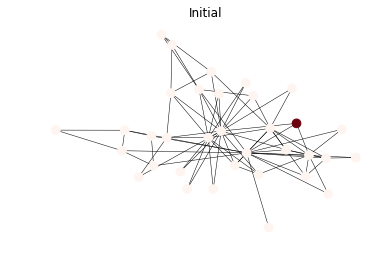

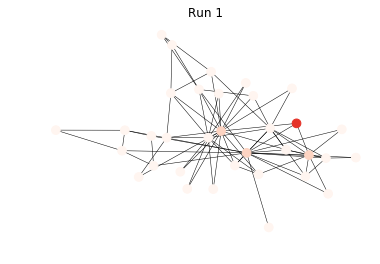

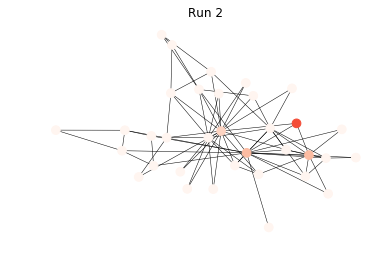

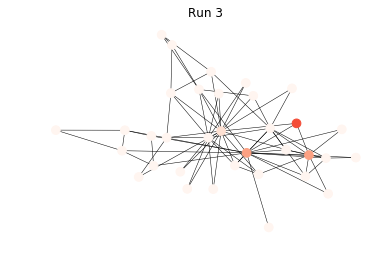

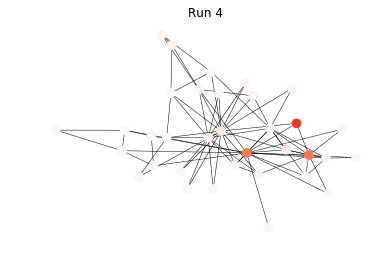

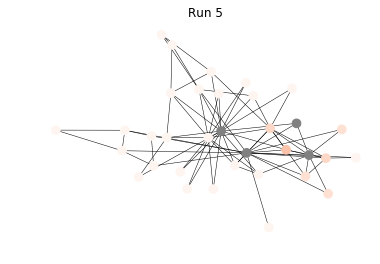

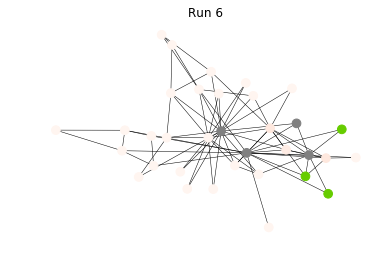

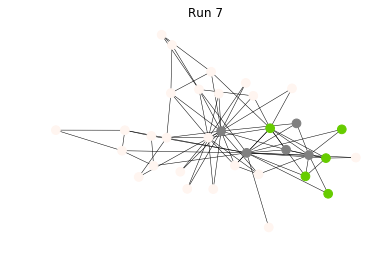

In [72]:
n = 100
g = random_network(n,0.03)
#sus_dict = {i:(i+0.1)/n for i in range(n)}

# n = 10
# g = nx.complete_graph(n)

g = nx.karate_club_graph()
#g = nx.balanced_tree(3,3)
#g = nx.relaxed_caveman_graph(3, 10,0.01)

# m, n = 5,5
# g0 = nx.grid_2d_graph(m, n)
# g = nx.convert_node_labels_to_integers(g0)

max_runs = 20
init_infect = 1

beta = 0.5
duration = 3
#duration = np.inf   # for SI, no recorvery
time_to_kill = 3
recovery = True
run_sim(g,beta,duration,max_runs,time_to_kill,recovery,init_infect)

# Demos:

In [75]:
m, n = 7,7
g0 = nx.grid_2d_graph(m, n)
g = nx.convert_node_labels_to_integers(g0)

max_runs = 20
init_infect = {24:1}

beta = 0.5

# SI

- No healing
- No deaths

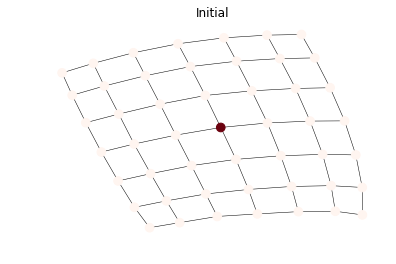

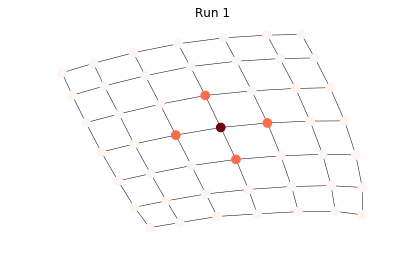

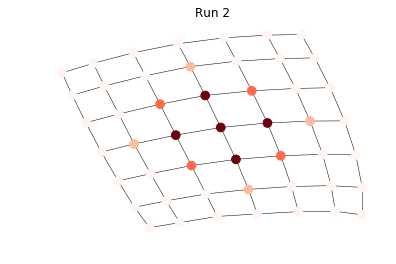

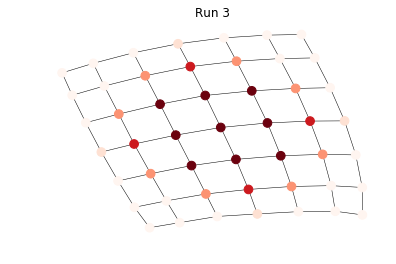

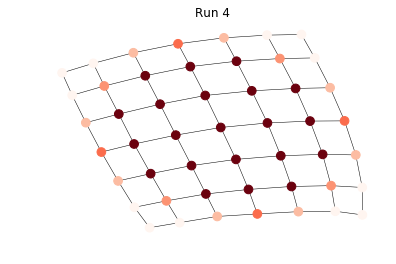

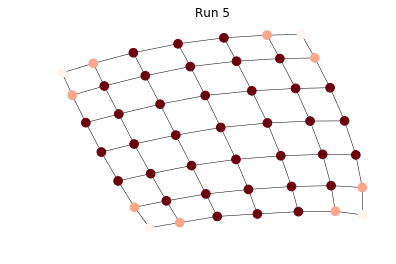

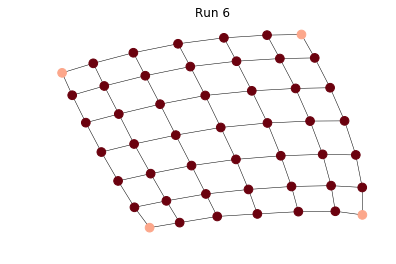

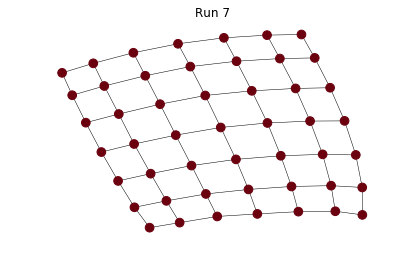

In [52]:
duration = np.inf
time_to_kill = np.inf
recovery = False # not needed as no one recovers anyway

run_sim(g,beta,duration,max_runs,time_to_kill,recovery,init_infect)

# SIS

- Healing
- No deaths

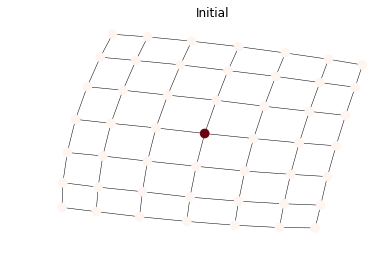

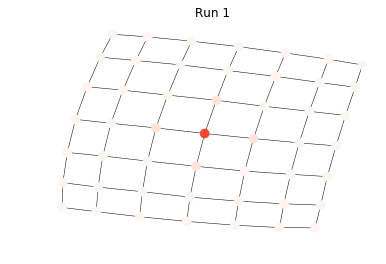

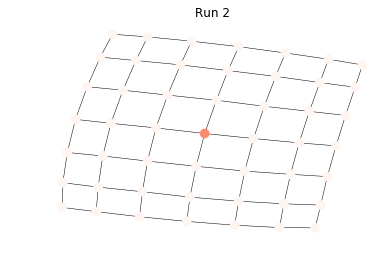

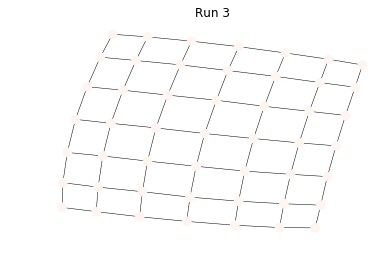

In [80]:
duration = 2.5
time_to_kill = np.inf
recovery = False

run_sim(g,beta,duration,max_runs,time_to_kill,recovery,init_infect)

# SIR

- Heals and immune post-recovery
- No deaths

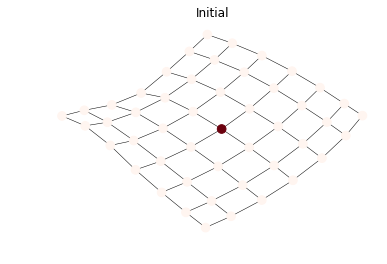

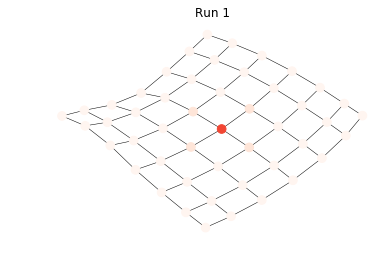

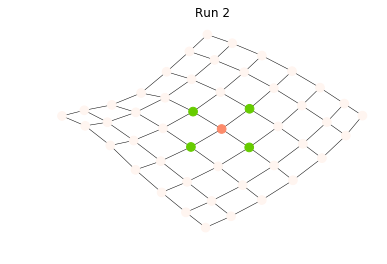

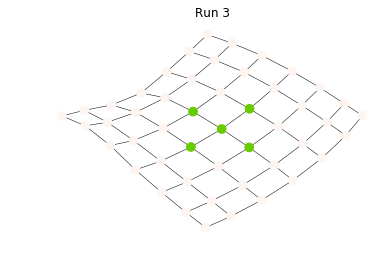

In [81]:
duration = 2.5
time_to_kill = np.inf
recovery = True

run_sim(g,beta,duration,max_runs,time_to_kill,recovery,init_infect)

# Vitality

- All above models can incorporate deaths by setting finite time_to_kill: rounds before an infected node dies.

# Many nodes....

TO DO:

- Gather metrics and plot...

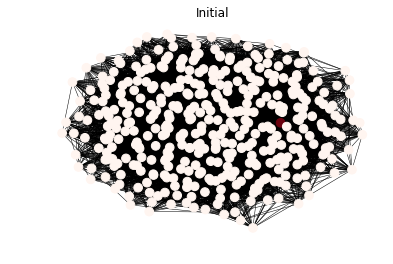

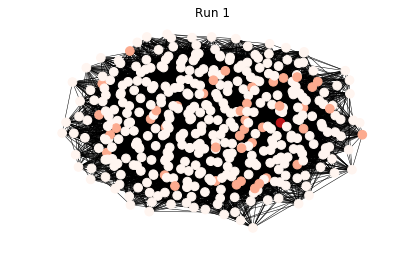

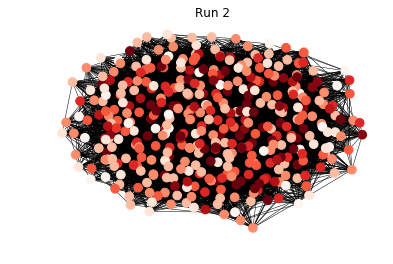

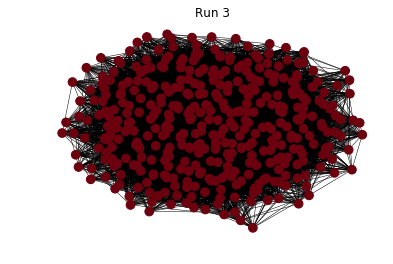

In [86]:
n = 400
g = random_network(n,0.1)

max_runs = 20
init_infect = {24:1}

beta = 0.5
duration = 5
time_to_kill = np.inf
recovery = True

run_sim(g,beta,duration,max_runs,time_to_kill,recovery,init_infect)